<img src="https://dootoo.app/images/thoughtswork_banner.png"/>

# DataTalks.club MLOps Zoomcamp Final Project: Task Completion Prediction

* **Author:** Paul Tongyoo
* **Contact:** Message me on <a href="https://www.linkedin.com/in/paultongyoo/">LinkedIn</a>
* **Date:** July 7, 2025
* **MLOps Zoomcamp Info:** <a href="https://datatalks.club/blog/mlops-zoomcamp.html">MLOps Zoomcamp: MLOps Course & Certification</a>

## Table of Contents

1. [Source Data](#Source-Data)
    1. [Data Set Creation](#Data-Set-Creation)
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    1. [Target Analysis ("is_done")](#Target-Analysis-is_done)
    1. [Parent/Child Status](#ParentChild-Status)
    1. [Task Publicity](#Task-Publicity)
1. [Data Preparation](#Data-Preparation)
1. [Model Training](#Model-Training)

In [1]:
import json
import os
import re

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from mlflow.models import infer_signature
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
from xgboost import XGBClassifier

## Source Data

In [2]:
# Create DB load function for later incorporation into pipeline


def load_latest_db_data():
    """Load data from the database and save it to a Parquet file."""
    load_dotenv()

    db_host = os.getenv("DB_HOST")
    db_port = os.getenv("DB_PORT")
    db_name = os.getenv("DB_NAME")
    db_user = os.getenv("DB_USER")
    db_password = os.getenv("DB_PASSWORD")

    db_url = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
    engine = create_engine(db_url)

    year_ago_cutoff_date = pd.Timestamp.now() - pd.DateOffset(years=1)
    first_done_at = pd.read_sql(
        """
        SELECT MIN("doneAt") AS first_doneAt
        FROM public."Item"
        WHERE "doneAt" IS NOT NULL
        """,
        engine,
    ).iloc[0]["first_doneAt"]
    tasks_df = pd.read_sql(
        """
        SELECT * FROM public.\"Item\" 
        WHERE "createdAt" >= %(cutoff_date)s
          AND "createdAt" >= %(first_doneAt)s
        """,
        engine,
        params={"cutoff_date": year_ago_cutoff_date, "first_doneAt": first_done_at},
    )

    # Save to Parquet file
    print("Saving tasks to Parquet file...")
    tasks_df.to_parquet("dootoo_item_prediction.parquet", index=False)
    print("Tasks saved to dootoo_item_prediction.parquet.")

    return tasks_df

In [3]:
if not os.path.exists("dootoo_item_prediction.parquet"):
    print("Parquet file not found. Loading from database...")
    full_tasks_df = load_latest_db_data()
else:
    print("Loading tasks from Parquet file...")
    full_tasks_df = pd.read_parquet("dootoo_item_prediction.parquet")
    print(f"Loaded {len(full_tasks_df)} tasks from Parquet file.")

Loading tasks from Parquet file...
Loaded 332 tasks from Parquet file.


In [4]:
full_tasks_df.shape

(332, 21)

In [5]:
full_tasks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      332 non-null    int64         
 1   user_id                 332 non-null    int64         
 2   is_child                332 non-null    bool          
 3   rank_idx                332 non-null    int64         
 4   is_done                 332 non-null    bool          
 5   createdAt               332 non-null    datetime64[ns]
 6   updatedAt               332 non-null    datetime64[ns]
 7   is_deleted              332 non-null    bool          
 8   uuid                    332 non-null    object        
 9   text                    332 non-null    object        
 10  embedding               247 non-null    object        
 11  parent_item_id          132 non-null    float64       
 12  event_id                13 non-null     object    

### Data Set Creation

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    full_tasks_df.drop(columns=["is_done"]),
    full_tasks_df["is_done"],
    test_size=0.2,
    random_state=42,
    stratify=full_tasks_df["is_done"],
)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((265, 20), (67, 20), (265,), (67,))

## Exploratory Data Analysis

In [8]:
# Combine X_train and y_train for easier analysis
combined_df = pd.concat([X_train, y_train], axis=1)

### Target Analysis ("is_done")

* Task completion rate is 36.6% completed
* Class imbalance necessitates tuning for both Precision and Recall
    * Model risks bias towards majority (`is_done==0`) class (low recall of `is_done=1`)

Task Completion Rate: 36.6%


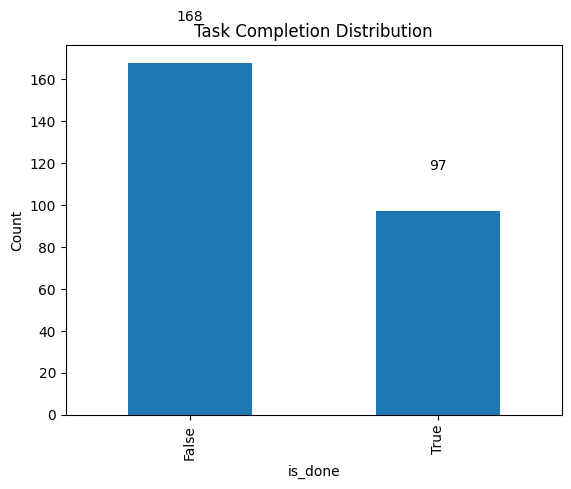

In [9]:
counts = combined_df["is_done"].value_counts()
print(f"Task Completion Rate: {combined_df['is_done'].mean() * 100:.1f}%")
counts.plot(kind="bar", title="Task Completion Distribution")
for i in range(len(counts)):
    plt.text(i, counts.iloc[i] + 20, counts.iloc[i], ha="center")
plt.xlabel("is_done")
plt.ylabel("Count")
plt.show()

*  We'll filter data set date range to start from the date of the first task completion to ensure we only model tasks that were created after the task completion feature was made available in the app.
* **First Task Created At:** `2024-11-08 07:26:26`
* **First Task Completed At:** `2025-01-15 13:30:37`

### Parent/Child Status

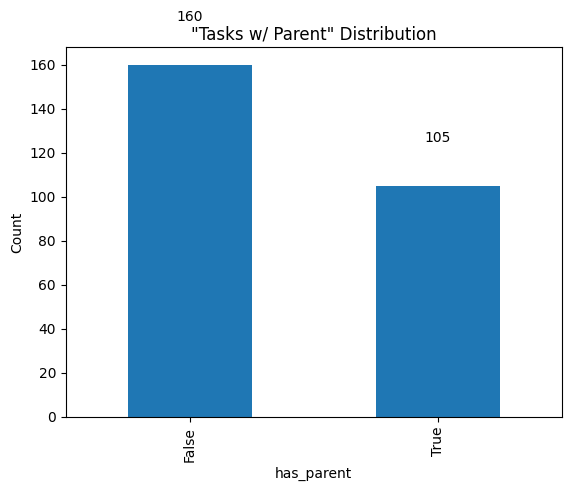

In [10]:
combined_df["has_parent"] = combined_df["parent_item_id"].notnull()
counts = combined_df["has_parent"].value_counts()
counts.plot(kind="bar", title='"Tasks w/ Parent" Distribution')
for i in range(len(counts)):
    plt.text(i, counts.iloc[i] + 20, counts.iloc[i], ha="center")
plt.xlabel("has_parent")
plt.ylabel("Count")
plt.show()

### Task Publicity

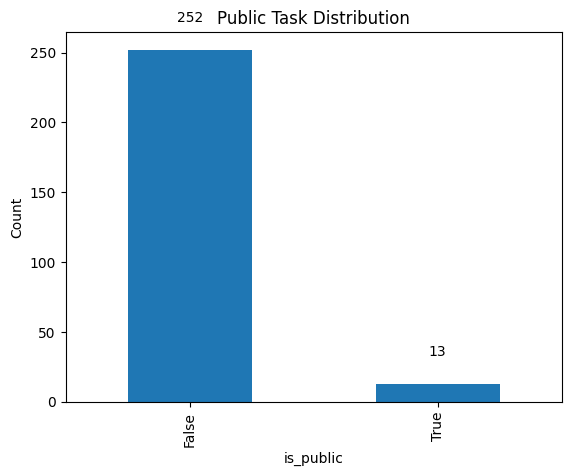

In [11]:
counts = combined_df["is_public"].value_counts()
counts.plot(kind="bar", title="Public Task Distribution")
for i in range(len(counts)):
    plt.text(i, counts.iloc[i] + 20, counts.iloc[i], ha="center")
plt.xlabel("is_public")
plt.ylabel("Count")
plt.show()

## Data Preparation

In [12]:
def prepare_data(tasks_df):
    """Prepare the data for modeling."""

    X = tasks_df.copy()

    # Extract date and time features from 'createdAt'
    X["createdAt"] = pd.to_datetime(X["createdAt"])
    X["year"] = X["createdAt"].dt.year
    X["month"] = X["createdAt"].dt.month
    X["day"] = X["createdAt"].dt.day
    X["hour"] = X["createdAt"].dt.hour  # 24-hour format
    X["day_of_week"] = X["createdAt"].dt.dayofweek  # 0=Monday, 6=Sunday

    # Create additional features
    X["has_parent"] = X["parent_item_id"].notnull().astype(int)
    X["task_age_days"] = np.where(
        X["doneAt"].notna(),
        (X["doneAt"] - X["createdAt"]).dt.days,
        (pd.Timestamp.now() - X["createdAt"]).dt.days,
    )

    # Reduce df columns to only those needed for modeling
    numerical_cols = [
        "year",
        "month",
        "day",
        "hour",
        "day_of_week",
        "rank_idx",
        "has_parent",
        "is_public",
        "task_age_days",
    ]
    return X[numerical_cols]

In [13]:
X_train_prepared = prepare_data(X_train)

## Model Training

In [14]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("dootoo_item_prediction")

2025/07/08 15:35:26 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/08 15:35:26 INFO mlflow.store.db.utils: Updating database tables


INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/home/pt7481/dev/dootoo_item_prediction/eda/mlruns/1', creation_time=1752007959681, experiment_id='1', last_update_time=1752007959681, lifecycle_stage='active', name='dootoo_item_prediction', tags={}>

In [15]:
def train_model(X, y):
    """Train the XGBoost model."""
    xgbc = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric="logloss",
    )
    xgbc.fit(X, y)
    return xgbc

In [16]:
clf = train_model(X_train_prepared, y_train)

In [17]:
def log_model_metrics(model, X, y, dataset_name="X_train"):
    """Log model metrics and parameters to MLflow."""
    with mlflow.start_run():
        mlflow.log_param("n_estimators", model.n_estimators)
        mlflow.log_param("max_depth", model.max_depth)
        mlflow.log_param("learning_rate", model.learning_rate)
        mlflow.log_param("random_state", model.random_state)

        mlflow.set_tag("dataset", dataset_name)

        # Obtain predictions of training data to evaluate model bias
        y_pred = model.predict(X)
        y_proba = model.predict_proba(X)

        log_loss_value = log_loss(y, y_proba)
        mlflow.log_metric("log_loss", log_loss_value)
        mlflow.log_metric("precision", precision_score(y, y_pred))
        mlflow.log_metric("recall", recall_score(y, y_pred))
        mlflow.log_metric("f1_score", f1_score(y, y_pred))
        mlflow.log_metric("accuracy", accuracy_score(y, y_pred))

        signature = infer_signature(X, y_pred)
        mlflow.xgboost.log_model(
            model,
            name="dootoo_item_prediction_model",
            signature=signature,
            input_example=X.sample(10),
        )

    conf_matrix = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix, display_labels=model.classes_
    )
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.show()

    pd.DataFrame(y_proba).plot(
        kind="density", title=f"Predicted Probabilities - {dataset_name}"
    )
    plt.xlabel("Probability")
    plt.ylabel("Density")
    plt.show()

/home/pt7481/.local/share/virtualenvs/dootoo_item_prediction-bxxed46J/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/pt7481/.local/share/virtualenvs/dootoo_item_prediction-bxxed46J/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [15:35:33] WARNING: /workspace/src/c_api/c_api.cc:14

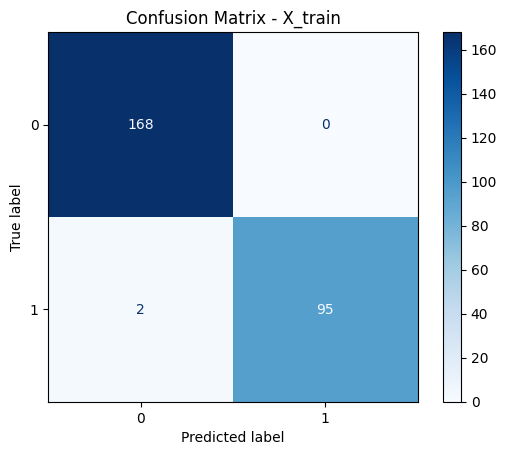

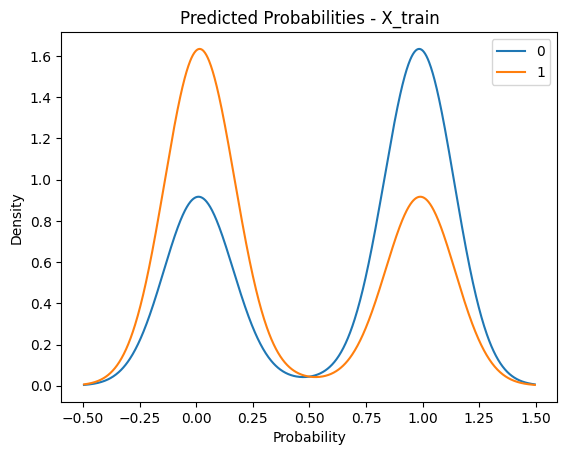

In [18]:
log_model_metrics(clf, X_train_prepared, y_train, dataset_name="X_train")

/home/pt7481/.local/share/virtualenvs/dootoo_item_prediction-bxxed46J/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/pt7481/.local/share/virtualenvs/dootoo_item_prediction-bxxed46J/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [15:35:36] WARNING: /workspace/src/c_api/c_api.cc:14

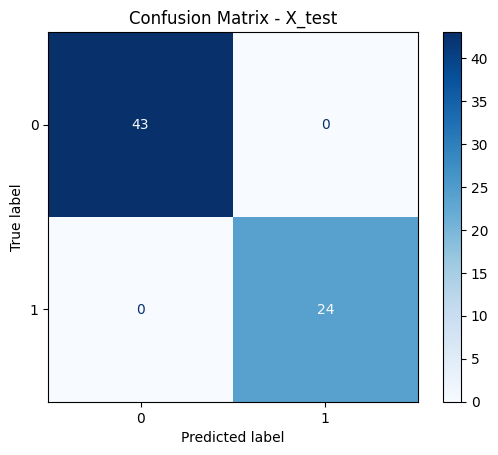

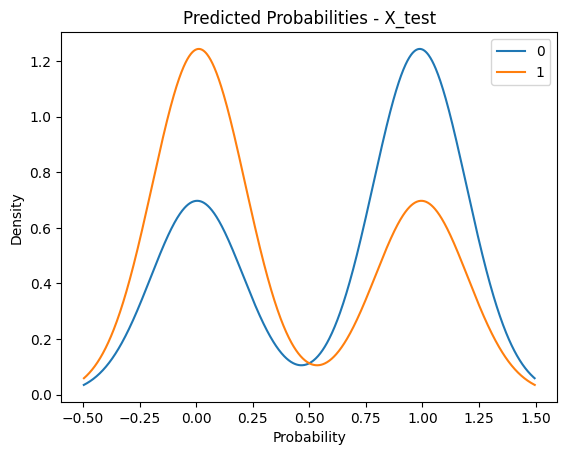

In [19]:
X_test_prepared = prepare_data(X_test)
log_model_metrics(clf, X_test_prepared, y_test, dataset_name="X_test")

------

In [20]:
def slugify(text):
    text = text.strip()
    text = re.sub(r"[^\w\s\-]", "", text)  # allow (), - and alphanumerics
    return re.sub(r"[\s]+", "-", text)


def extract_headings(ipynb_path):
    with open(ipynb_path, "r", encoding="utf-8") as f:
        nb = json.load(f)

    toc_lines = []  # ["## Table of Contents\n"]
    for cell in nb["cells"]:
        if cell["cell_type"] == "markdown":
            for line in cell["source"]:
                match = re.match(r"^(#{2,6})\s+(.*)", line)
                if match:
                    level = len(match.group(1)) - 1  # offset for nesting
                    title = match.group(2).strip()
                    anchor = slugify(title)
                    indent = "    " * (level - 1)
                    toc_lines.append(f"{indent}1. [{title}](#{anchor})")

    return "\n".join(toc_lines)


# Example usage:
TOC = extract_headings("dootoo_item_prediction.ipynb")
print(TOC)

1. [Table of Contents](#Table-of-Contents)
1. [Source Data](#Source-Data)
    1. [Data Set Creation](#Data-Set-Creation)
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    1. [Target Analysis ("is_done")](#Target-Analysis-is_done)
    1. [Parent/Child Status](#ParentChild-Status)
    1. [Task Publicity](#Task-Publicity)
1. [Data Preparation](#Data-Preparation)
1. [Model Training](#Model-Training)
